# A complete topology optimization algorithm

The goal of this notebook is to show you how to implement the various steps of a topology optimization algorithm. We consider the following compliance minimization problem:

$$
\begin{aligned}
\min & \qquad J(\Omega, u(\Omega))\\
s.t. & \qquad \mathrm{Vol}(\Omega)-\mathrm{Vol}_{target}=0
\end{aligned}
$$
where $u(\Omega)$ is the solution to
$$
\renewcommand{\u}{\textbf{u}}
\renewcommand{\f}{\textbf{f}}
\renewcommand{\In}{\text{ in }}
\renewcommand{\div}{\mathrm{div}}
\renewcommand{\Tr}{\mathrm{Tr}}
\newcommand{\On}{\textrm{ on }}
\newcommand{\n}{{\textbf n}}
\newcommand{\g}{\textbf g}
    \left\{\begin{aligned}
  -\div(Ae(\u)) &= \f \In \Omega \\
        \u &= 0 \On \partial\Omega^{D}\\
        Ae(\u)\cdot \n& = \g \On \partial \Omega^{N}\\
        Ae(\u)\cdot\n &= 0\On \Gamma.
    \end{aligned}\right.
$$
where
$$
A e(\u) = 2\mu e(\u) + \lambda \Tr(e(\u))I.
$$
The compliance and the volume are defined to be 
$$
J(\Omega,u(\Omega)):=\int_{\Omega}e(\u):e(\u)\mathrm{d} x,\qquad 
\mathrm{Vol}(\Omega):=\int_\Omega\mathrm{d} x.
$$
We will rely on `pyfreefem` and `pymedit`, and the null space optimizer for solving the optimization problem.

In [12]:
from pyfreefem import FreeFemRunner, readFFArray
from nullspace_optimizer import Optimizable, nlspace_solve
from pymedit import Mesh, P1Function, advect, mmg2d, mshdist, P1Vector, trunc
import numpy as np
import shutil

These lines will allow to have large outputs in this notebook:

In [13]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

We create an output directory where to put all the files:

In [14]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10,10]

output='output'
import os
os.makedirs(output,exist_ok=True)

config={'OUTPUT':output}

### 1. Creation of the initial mesh and the boundary conditions

**Question 1.1** Write a FreeFem code to generate a mesh of the rectangle $(-1,1)\times (-0.5,0.5)$ with some part constituted of a zero boundary Dirichlet condition, and some part constituted of a Neumann boundary condition with some load $\textbf{g}$.

You can check and adapt the code of the page [https://modules.freefem.org/modules/elasticity/](https://modules.freefem.org/modules/elasticity/) to see how to build a mesh in FreeFEM with boundary conditions. 

In [15]:
code_makemesh="""
// Define here the various boundaries at play with the above labels
border bd1 //TO FILL

mesh Th= //TO FILL
savemesh(Th,"$OUTPUT/Th_init.mesh");
"""
FreeFemRunner(code_makemesh,config={"OUTPUT":output}).execute(plot=True)

Th0 = Mesh(output+'/Th_init.mesh')

# Detect the corners, will prevent the corners to be smoothened due to remeshing
Th0=mmg2d(Th0,extra_args='-nomove -noswap -nosurf -noinsert',nr=False)
Th0.save(output+'/Th_init.mesh')
Th0.plot(title='Initial mesh',boundary='all',colormap='white');

**Question 1.2** We will consider as an initialization some material perforated with holes. Define a level set function defining  an initial topology of holes and which does not touch the upper and lower boundaries. Consider using product of sine functions for defining the holes (e.g. $\phi(x,y)=0.1-\sin(k\pi x)\sin(k\pi y)$)

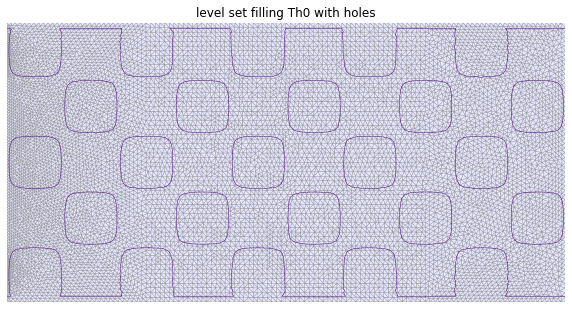

In [16]:
# Define a function defining the first level set
# This function should have the following syntax
# phi = lambda x : f(x[0],x[1]) where x[0] and x[1] refer to the x and y coordinates.

P1Function(Th0,phi0).plot(fill=False,title='level set filling Th0 with holes');


**Question 1.3** Adapt the code below to define a level set `cut` with some non optimizable regions around your boundaries and a level set `phiCut` defining the prescribed distribution of materials within these boundaries:

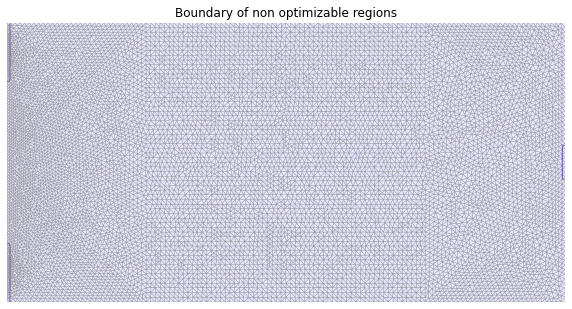

In [17]:
epsCut = 0.005*2

def corners(x): return max(x[0]+1-epsCut,
                           min(0.3-epsCut-x[1], 0.3-epsCut+x[1]))
def load(x): return max(abs(x[1])-0.05-epsCut, 1-epsCut-x[0])

def cut(x): return -min(corners(x), load(x))

def phiCut(x): return cut(x)

P1Function(Th0,cut).plot(fill=False,title='Boundary of non optimizable regions');

**Question 1.4** Construct an initial level set function `phiinit` by enforcing the non optimizable regions in the levelset function `phi0` We recall that the non-optimizable regions `cut(x)<0` filled with the material `phiCut` (negative for fluid, positive for solid) can be enforced by applying the following post treatment on the level set:
\begin{equation}
    \label{eqn:posttreatment} 
    \phi\gets \min(\max(\phi,-\texttt{phicut}),\max(\texttt{cut},\texttt{phicut})),
\end{equation}
Then, construct a mesh adapted to `phiinit` by remeshing with `mmg2d`.

mmg2d_O3 -nr -hmin 0.02 -hmax 0.1 -hgrad 1.3 -hausd 0.002 -ls -sol /tmp/tmpvtg1ysq0/Th.solb /tmp/tmpvtg1ysq0/Th.meshb (0.11s)


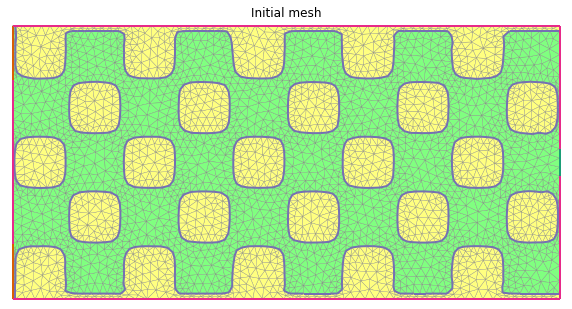

In [18]:
phiinit = # FILL YOURSELF

# Meshing parameters
hmin = 0.02 # Minimum edge size (try to change it !)
hmax = 0.1 # Maximum edge size
hgrad = 1.3 # Gradation factor 
hausd = 0.1*hmin # Approximation quality factor, leave as it is

# Local parameter to prescribe local mesh size on the interface boundary 10 (corresponding to the level set)
paramsmmg = f"""Parameters
1
 
10 Edges {hmin} {hmax} {hausd}
"""

phiinit=P1Function(Th0,phiinit)
phiinit.plot(title='level set init',fill=False)

# Mesh with mmg2d 
Thinit = mmg2d(Th0,hmin,hmax,hgrad,hausd,ls=True,nr=True,sol=phiinit,params=paramsmmg,debug=1)

Thsinit = trunc(Thinit,2) #Trunc the solid mesh
Thinit.plot(title='Initial mesh',boundary='all');
Thinit.save(output+'/Th0.mesh')
Thsinit.plot(title='Solid mesh');

## 2. Creation of the direct solver and evaluation of the objective and constraint

We now turn on writing a function `computeU` which given an input mesh (given as a file name), computes the displacement field $u$ and the objective and constraint functionals. We will use the following FreeFEM code as a preamble which provides useful functions.

In [19]:
preamble="""
func int readSolFile(mesh & Th, string fileName, real[int] & phi){
    ifstream f(fileName);
    string dummy="";
    while(dummy(0:2)!="Sol"){
        f>>dummy;
    }
    int n;
    f >> n;
    if(n!=Th.nv){
        cout << "Error : the number of vertices in the file "+fileName+" does not correspond to the mesh in memory"<< endl;
        exit(1);
    }
    f >> dummy;
    f >> dummy;
    for(int i=0;i<Th.nv;i++){
        f>>phi[i];
    }
}

func int saveArray(string fileName, real[int] &value){
    ofstream file(fileName);
    file.precision(16);
    file << value;
}

func int readData(string fileName, real[int] &data){
    {
        ifstream f(fileName);
        f>>data;
    }
}


load "medit";//for savesol and readmesh
real E=15; // Young modulus
real poisson=0.35; // Poisson ratio

real lambda=E*poisson/((1.+poisson)*(1.-2.*poisson)); //Lamé parameters
real mu=E/(2.*(1.+poisson));

// Macros for differential operators
real sqrt2=sqrt(2);
macro grad(u) [dx(u),dy(u)]//
macro e(vx,vy) [dx(vx),dy(vy),(dx(vy)+dy(vx))/sqrt2]//
macro div(vx,vy) (dx(vx)+dy(vy))//

real VolumeFractionTarget=0.3;
"""

FreeFem++ output/solve_state.edp -v 0 -nw
 (0.15s)


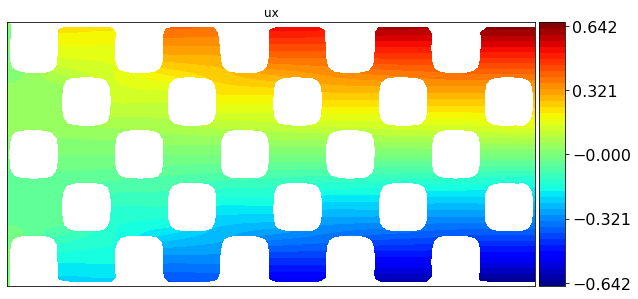

J=0.1909922501764831
G=0.2632524691581882


In [11]:
solve_code='''
mesh Th=readmesh("$MESH"); //$MESH is a ``magic variable'' which will be automatically replaced 
mesh Ths=readmesh("$THS");

real Vth=int2d(Th)(1.);// Total volume

// forces 
func gx=//FILL YOURSELF
func gy=//FILL YOURSELF

// Variational space for linear elasticity
fespace Fhs12d(Ths,[P1,P1]);
Fhs12d [ux,uy],[rx,ry];//Test functions

varf linearElasticity([ux,uy],[rx,ry])=//TO FILL

matrix linElasMat=linearElasticity(Fhs12d,Fhs12d);

varf elasticityRHS([ux,uy],[rx,ry])=//TO FILL
            
real[int] rhs=elasticityRHS(0,Fhs12d);
ux[]=linElasMat^-1*rhs; //Solution of the linear system

//save the solution
saveArray("$OUTPUT/u.gp",ux[]);
savesol("$OUTPUT/ux.sol",Ths,ux,order=1);
savesol("$OUTPUT/uy.sol",Ths,uy,order=1);

//Compute objective and constraints
real J=//FILL YOURSELF
real G=//FILL YOURSELF
//Save their value in a file that python can read
{
    ofstream f("$OUTPUT/J.gp");
    f.precision(16);
    f << J << endl;
}


{ 
    ofstream f("$OUTPUT/G.gp");
    f.precision(16);
    f << G << endl;
}
'''

def computeU(mesh):
    M = Mesh(mesh)
    Ths = trunc(M,2) #Trunc the mesh in python
    Ths.save(output+'/Ths.mesh')
    FreeFemRunner([preamble,solve_code],config,script_dir=output,run_file='solve_state.edp',debug=1).execute({'MESH':mesh,'THS':output+'/Ths.mesh'});
    with open(output+'/J.gp','r') as f:
        J = float(f.readlines()[0])
    with open(output+'/G.gp','r') as f:
        G = float(f.readlines()[0])
    return (J,G)

(J,G)=computeU(output+'/Th0.mesh')
ux = P1Function(Thsinit,output+'/ux.sol') #Plot x component
ux.plot(title='ux')
uy=P1Function(Thsinit,output+'/uy.sol') # Plot y component
uy.plot(title='uy');
P1Vector(Thsinit,[ux,uy]).plot(title='u') # Plot displacement
print(f"J={J}")
print(f"G={G}")

You can check the file [output/solve_state.edp](output/solve_state.edp) which has been written and run by FreeFEM from python.

### 3. Shape sensitivities

The next step is to write a function which given the current mesh, returns the linear differential form associated with the shape derivatives of the objective and constraint. We have the shape derivative formula:
$$
\newcommand{\D}{\mathrm{d}}
\newcommand{\r}{\mathbf{r}}
  \frac{\D}{\D\theta}\Big[ J(\Gamma,\u(\Gamma))\Big]
  (\theta)=
  \frac{\partial \mathfrak{J}}{\partial\theta}(\theta)+\int_{\Omega_s} \left[-\div(\theta)A e(\u):\nabla\r 
    +A e(\u):(\nabla\r\nabla\theta)+Ae(\r):(\nabla\u\nabla\theta)\right]\D x,
$$
where $\r$ is the adjoint state solution to 
$$
\int_\Omega Ae(\r):e(\r')\D x = \frac{\partial\mathfrak J}{\partial \hat \u}(\r') \qquad \forall \r' \in V_{\u}.
$$
Here we have 
$$
\frac{\partial \mathfrak{J}}{\partial \hat \u}(\r')=\int_\Omega 2 Ae(\u):e(\r')\D x
$$
hence it is clear that the adjoint state for $C$ is $\r=2\u$ (the problem is said self adjoint). Since 
$$
  \frac{\partial \mathfrak J}{\partial\theta}(\theta)=
  \int_{\Omega_s}( A
e(\u):e(\u)\div(\theta)-2Ae(\u):(\nabla\u\nabla\theta))\D x , 
$$
we eventually find 
$$
  \frac{\D}{\D\theta}\Big[ J(\Gamma,\u(\Gamma))\Big]
  (\theta)=\int_{\Omega_s}(- A
e(\u):e(\u)\div(\theta)+2Ae(\u):(\nabla\u\nabla\theta))\D x
$$
where the normal points outward $\Omega_f$. We also recall that 
$$
\frac{\D}{\D\theta}\Big[ \mathrm{Vol}(\Omega_s)\Big]
  (\theta)=\int_{\Omega_s}\div(\theta)\D x.
$$

**Question 3** Fill the code below to assemble the shape derivative of the objective and constraint functions.

In [21]:
code_sensitivity=f"""
mesh Th=readmesh("$MESH");
mesh Ths=readmesh("$THS");

real Vth=int2d(Th)(1.);// Total volume

//Read the solution u

fespace Fhs12d(Ths,[P1,P1]);
Fhs12d [ux,uy],[rx,ry];//Test functions

readData("$OUTPUT/u.gp",ux[]);


//Finite element space for the deformation field
fespace Gh1(Th,[P1,P1]); // space for deformation field theta
Gh1 [thetax,thetay],[thetaxp,thetayp];

//Additional differential operator macros for computing term e(u):(\nabla u\nabla \theta)
macro dotdAdBsym(vx,vy,thetax,thetay) [ dx(vx)*dx(thetax)+dy(vx)*dx(thetay),
    dx(vy)*dy(thetax)+dy(vy)*dy(thetay),
    (dx(vx)*dy(thetax)+dy(vx)*dy(thetay)
    +dx(vy)*dx(thetax)+dy(vy)*dx(thetay))/sqrt2 ]//

//Additional differential opreator macro for computing term Tr(\nabla u\nabla \theta)
macro trdAdB(vx,vy,thetax,thetay) (dx(vx)*dx(thetax)+dy(vx)*dx(thetay)+dx(vy)*dy(thetax)+dy(vy)*dy(thetay))//


varf shapeDerivativeJ([thetax,thetay],[thetaxp,thetayp])
    =//FILL YOURSELF
        
real[int] diffJ=shapeDerivativeJ(0,Gh1); // Assemble the shape derivative
saveArray("$OUTPUT/diffJ.gp",diffJ);


varf shapeDerivativeG([thetax,thetay],[thetaxp,thetayp])= //FILL YOURSELF
real[int] diffG=shapeDerivativeG(0,Gh1);//Assemble the shape derivative
saveArray("$OUTPUT/diffG.gp",diffG);
"""
def sensitivity(mesh):
    M = Mesh(mesh)
    Ths = trunc(M,2)
    Ths.save(output+'/Ths.mesh')
    FreeFemRunner([preamble,code_sensitivity],config,script_dir=output,run_file='sensitivities.edp',debug=1).execute({'MESH':mesh,'THS':output+'/Ths.mesh'})
    dJ=readFFArray(output+'/diffJ.gp')
    dG=readFFArray(output+'/diffG.gp')
    return (dJ,dG)

(dJ,dG)=sensitivity(output+'/Th0.mesh')
print(f"dJ={dJ}")
print(f"dG={dG}")

FreeFem++ output/sensitivities.edp -v 0 -nw
 (0.18s)
dJ=[ 0.          0.          0.         ... -0.00132175 -0.00022222
  0.0007204 ]
dG=[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.16840434e-19
  2.81892565e-18 -1.62630326e-19]


### 4. Inner product to compute shape gradients

We then need to provide a function which can convert these shape derivatives into gradients, by solving the regularization problem
$$
\langle \nabla J,\theta'\rangle_V=\mathrm{D}J(\Omega)\cdot\theta' \qquad \text{ for any }\theta'\in V
$$
with 
$$
    V=\{ \theta \in H^1(\Omega,\mathbb R^d)\,|\, \theta= 0 \On \omega \}
$$
where we recall that $\omega$ is the non-optimizable region. We choose
$$
\langle \theta,\theta'\rangle_V=\int_D (\gamma^2 \nabla \theta : \nabla \theta'+\theta\cdot\theta')\D x
+\texttt{tgv}\int_{\omega} \theta\cdot\theta'\D x.
$$
with $\gamma=10\texttt{hmin}$. 
The constant `tgv` is a very large value which allows to enforce `\theta=0` on $\omega$ by penalization. 

**Question 4** Fill the following code appended to the code computing shape derivatives which computes their gradient. Plot the gradient and the shape derivative, compare and comment.

FreeFem++ output/sensitivities.edp -v 0 -nw
 (0.25s)
dJ=[ 0.          0.          0.         ... -0.00132175 -0.00022222
  0.0007204 ]
dG=[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.16840434e-19
  2.81892565e-18 -1.62630326e-19]
gradJ=[-0.02074479 -0.04937047  0.08271282 ...  2.65174764 -0.0645802
  0.12495068]
gradG=[ 1.30066575  1.65512483 -0.1675433  ... -0.29524232  0.4229696
 -0.26819541]


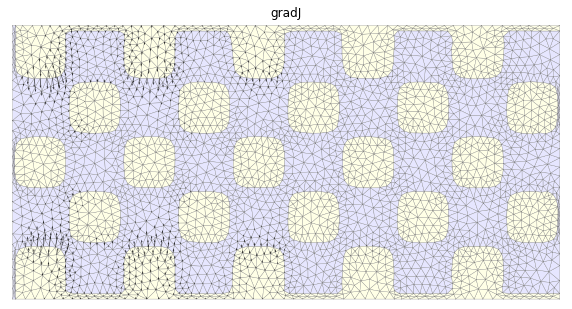

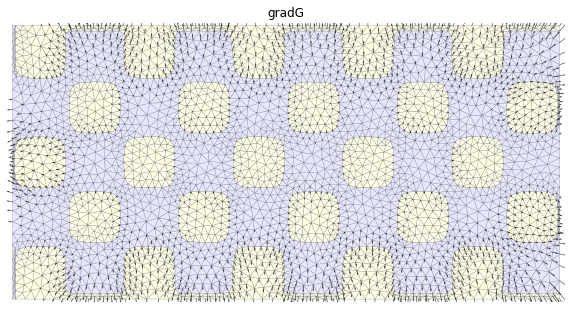

In [22]:
code_gradient = """
/*
Note: this code will be appended to code_sensitivity defined above.
*/

tgv=1e16;
real gamma = (10*$hmin);

//Cut function : ADAPT THE CODE BELOW to your own boundary conditions, correpsonding to the non optimizable region 
//as in Question 1.3
real epsCut=0.005*2;
func cut=-min(max(x+1-epsCut,min(0.3-epsCut-y,0.3-epsCut+y)),max(abs(y)-0.05-epsCut, 1-epsCut-x));

fespace Fh1(Th,P1);
Fh1 cutp1=cut>0;// Get the vertices of the non optimizable region


varf innerproduct([thetax,thetay],[thetaxp,thetayp])=//TO FILL 

//Compute the gradients from the shape derivatives diffJ and diffG:
real[int] gradJ = // TO FILL
real[int] gradG = //TO FILL

saveArray("$OUTPUT/gradJ.gp",gradJ);
saveArray("$OUTPUT/gradG.gp",gradG);
"""
def sensitivity(mesh):
    FreeFemRunner([preamble,code_sensitivity,code_gradient],config,script_dir=output,run_file='sensitivities.edp',debug=1).execute({'MESH':mesh,'hmin':hmin})
    dJ=readFFArray(output+'/diffJ.gp')
    dG=readFFArray(output+'/diffG.gp')
    gradJ=readFFArray(output+'/gradJ.gp')
    gradG=readFFArray(output+'/gradG.gp')
    return (dJ,dG,gradJ,gradG)

(dJ,dG,gradJ,gradG)=sensitivity(output+'/Th0.mesh')
print(f"dJ={dJ}")
print(f"dG={dG}")
print(f"gradJ={gradJ}")
print(f"gradG={gradG}")
P1Vector(Thinit,[dJ[::2],dJ[1::2]]).plot(title='dJ')
P1Vector(Thinit,[gradJ[::2],gradJ[1::2]]).plot(title='gradJ')
P1Vector(Thinit,[dG[::2],dG[1::2]]).plot(title='dG')
P1Vector(Thinit,[gradG[::2],gradG[1::2]]).plot(title='gradG')

Observe the difference between dG and the gradient !
Observe the enforcement of $\theta=0$ on non optimizable regions.

### 5. The retraction or shape update

We then need a function which takes a descent direction, a current mesh (given as the name of a file), and returns a new updated mesh. We use the level set mesh evolution method. 

First: compute a level set function adapted to the current mesh. We use the signed distance function from `mshdist`.

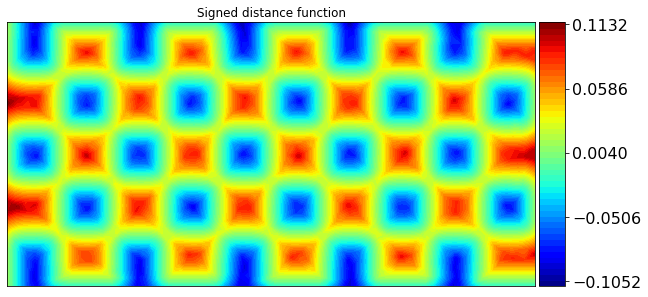

In [14]:
phi = mshdist(Thinit)
phi.plot(title="Signed distance function");

Advect the level set function from a time step dt. We use the gradient of the constraint as an example vector field (later it is provided by the nullspace algorithm):

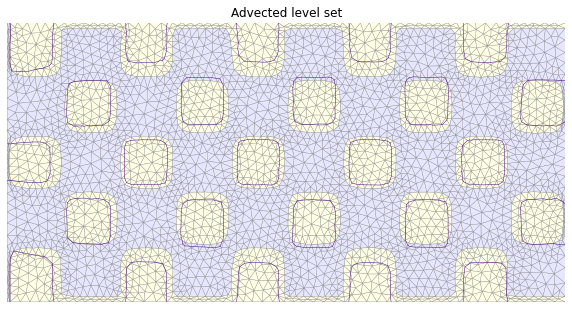

In [25]:
dt = 3*hmin
xi = P1Vector(Thinit,[gradG[::2],gradG[1::2]])
phiNew = advect(Thinit,phi,dt*xi,T=1)
phiNew.plot(fill=False,title="Advected level set");

Make sure that the non optimizable regions are enforced (this step was already enforced in the advection step, but this way we are sure):

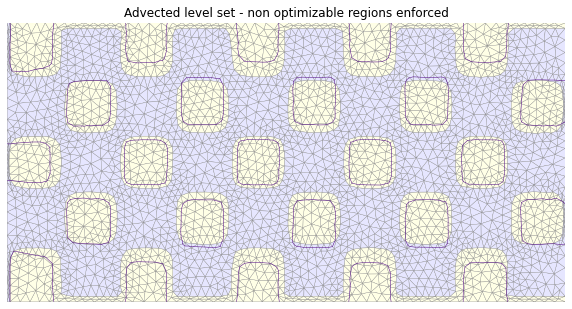

In [26]:
cutP1 = P1Function(Thinit,cut)
phiCutP1 = P1Function(Thinit,phiCut)
phiNew.sol = np.minimum(np.maximum(phiNew.sol,cutP1.sol),np.maximum(phiCutP1.sol,-cutP1.sol))
phiNew.plot(fill=False,title="Advected level set - non optimizable regions enforced");

In a last step we regularize the level set, which is important before remeshing. We regularize a levelset $\phi_0$ by solving the variational problem
$$
\int_D \gamma^2 \nabla \phi\cdot\nabla \psi + \phi\psi\mathrm{d} x= \int_D \phi_0 \psi\D x,
$$
where $\gamma$ is a small diffusion parameter. 

**Question 5.1**
Fill the code below to regularize the previous level set function `phiNew`.

In [29]:
codeRegularize="""
mesh Th=readmesh("$MESH");
fespace Fh(Th,P1);
Fh phi0, phi, psi;
readSolFile(Th,"$SOL",phi0[]);

real gamma=0.01*$hmin;

solve regularize(phi,psi)=
   //TO FILL

savesol("$OUTPUT/phireg.sol",Th,phi,order=1);
"""
phiNew.save(output+'/phi.sol')
FreeFemRunner([preamble,codeRegularize],config,script_dir=output,run_file='regularize.edp',debug=1).execute({'MESH':output+'/Th0.mesh','SOL':output+'/phi.sol','hmin':hmin})
P1Function(Thinit,output+'/phireg.sol').plot(title='Regularized',fill=False)

FreeFem++ output/regularize.edp -v 0 -nw
 (0.10s)


(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Regularized'}>)

Remesh to obtain the new domain (the `-rmc` argument remove small components).

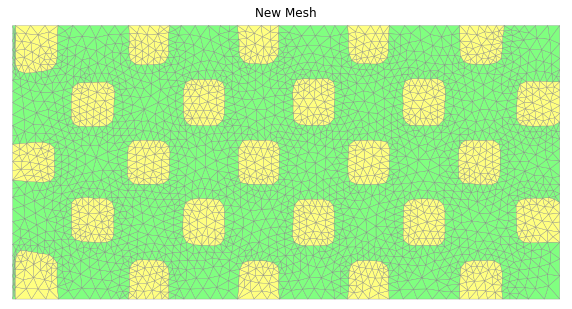

In [28]:
newM=mmg2d(Thinit,hmin,hmax,hgrad,hausd,ls=True,sol=phiNew,extra_args="-rmc")
newM.plot(title="New Mesh");

We now implement all these steps in a single function:

FreeFem++ output/sensitivities.edp -v 0 -nw
 (0.13s)
mmg2d_O3 -nr -hmin 0.02 -hmax 0.1 -hgrad 1.3 -hausd 0.002 -ls -sol /tmp/tmpdg7guoxr/Th.solb /tmp/tmpdg7guoxr/Th.meshb (0.07s)


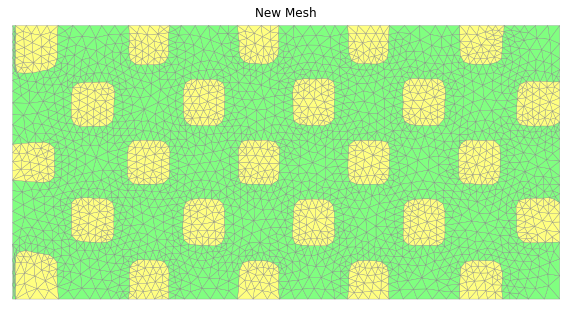

In [30]:
def shapeUpdate(mesh, xi):
    M = Mesh(mesh)
    # Build an initial level set from the mesh
    
    # Advect the level set with a velocity field given by xi (advect for a total time 1)
    # Be careful that xi is a column vector
        
    # Enforce non optimizable regions
    
    # Regularize the level set
    
    # Remesh according to the new level set
    newM=#FILL
    
    newM.save(output+'/Th.o.mesh')
    return output+'/Th.o.mesh'

newM = shapeUpdate(output+'/Th0.mesh',dt*gradG)
Mesh(newM).plot(title='New Mesh')

### 6. The complete optimization procedure: null space algorithm

**Question 6** Insert now all the above ingredient in the null space algorithm. For this, fill in the `Optimizable` class below, which gathers all the ingredients required for the optimization. Use the functions `computeU`, `sensitivity`, `shapeUpdate` defined above.

In [31]:
class Cantilever(Optimizable):
    def __init__(self):
        super().__init__()
        # Use the two following variables to avoid redoing computations, see below
        self.ucomputed = False
        self.sensitivity_computed = False
        # A variable to store the objective and constraints, see below
        self.obj = None
        self.nconstraints = 1
        self.nineqconstraints = 0
        
    ############################ Initialization #############################
    def x0(self):
        # Return the initial mesh file path
        return #To Fill
    
    ####################### Objective function and constraints ############
    
    #Use this auxiliary function to compute both objective and constraint at once
    def evalObjective(self, x):
        if not self.ucomputed:
            #To fill
            (J,G) = 
            self.ucomputed = True
            self.obj = (J,G)
        return self.obj
    
    # Return the value of the objective function
    def J(self,x):
        # To fill
    
    # Return the value of the constraint
    def G(self,x):
        # To fill
    
    ######################### Shape derivatives and shape gradients #########
    
    # use this auxiliary function to compute shape derivatives and grdients at once
    def evalSensitivities(self,x):
        if not self.sensitivity_computed:
            (dJ,dG,gradJ,gradG)=#To fill
            self.sensitivity_computed = True
            self.sensitivities = (dJ,dG,gradJ,gradG)
        return self.sensitivities
    
    def dJ(self,x):
        # To fill
    
    def dG(self,x):
        # To fill
        
    #Gradient and transpose
    def dJT(self,x):
        # To fill
    
    def dGT(self,x):
        # To fill
    
    ########################## Retraction : shape update #################"
    def retract(self, x, dx):
        # Assume that the next computations will be performed on the new retracted
        # mesh -> erase the current solutions and sensitivities
        self.sensitivity_computed = False
        self.ucomputed = False
        
        # Return the updated shape
        return 
    
    ####################### Accept step : save the current result#########
    def accept(self,results):
        # results is a variable updated by the optimizer
        # accept is called everytime a new guess is accepted
        # The following lines save the current mesh to an appropriate 
        # output folder, and plot the optimized mesh every two iterations
        mesh = results['x'][-1]
        niter = len(results['J'])-1
        itf = format(niter,'04d')
        shutil.copyfile(mesh,output+'/Th_'+itf+'.mesh')
        M = Mesh(mesh)
        if np.mod(niter ,2)==0:
            M.plot(title=f'Iteration {niter}')
        results['x'][-1] = output+'/Th_'+itf+'.mesh'
        


**Question 6.2** Run the optimization !

In [ ]:
optSettings = {'dt':hmin,'alphaJ':1.5,'alphaC':0.5, 'maxit':100, 'provide_gradient': True, 'maxtrials':3,
              'itnormalisation': 3}
results=nlspace_solve(Cantilever(), optSettings)

Comment on the optimized design above: body-fitted meshes, aspect of the optimized shape, topological changes ?

**Question 6.3** Plot the objective and constraint functionals (use the variable `results` of the output of the null space optimizer). Comment.

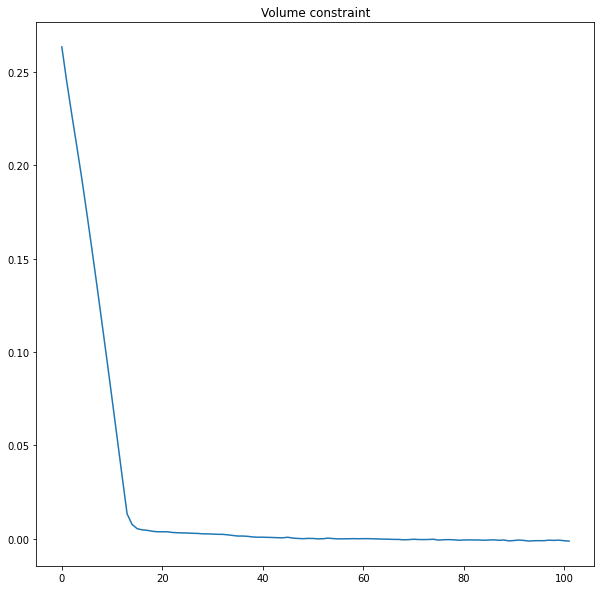

In [34]:
import matplotlib.pyplot as plt
# To fill